In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [0]:
from fastai import *
from fastai.vision import *

In [0]:
bs = 64

In [0]:
path = untar_data(URLs.PETS)

In [0]:
path /= 'images'

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [0]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [0]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
data = get_data(224, bs, 'zeros')

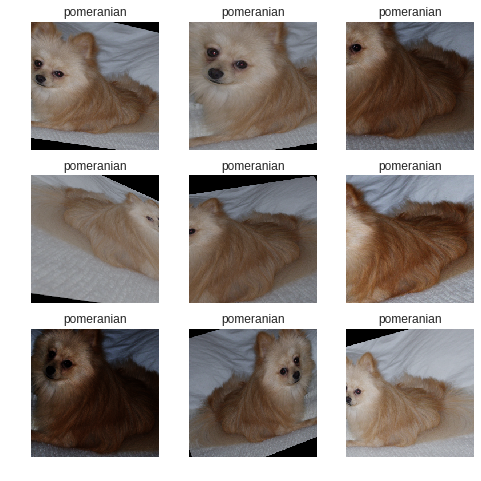

In [10]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [11]:
gc.collect()
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 92457004.84it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01


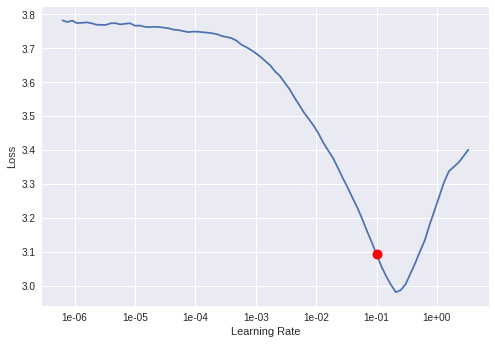

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,2.573589,1.319745,0.265900
2,1.519910,0.337348,0.085250
3,0.932874,0.269216,0.066982


In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


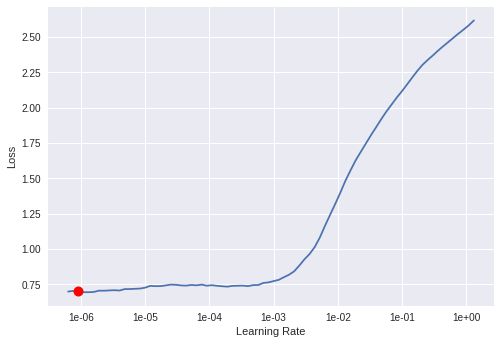

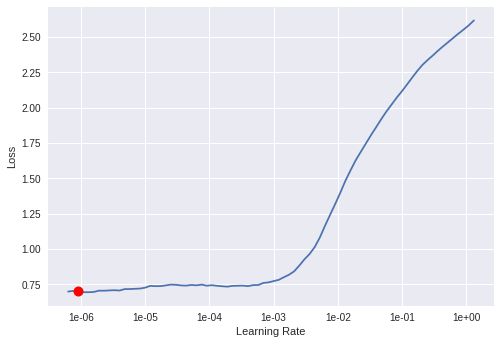

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-4), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,0.702312,0.293426,0.068336
2,0.676934,0.301869,0.064276


In [0]:
data = get_data(352, bs)  # 352x352 larger data
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06


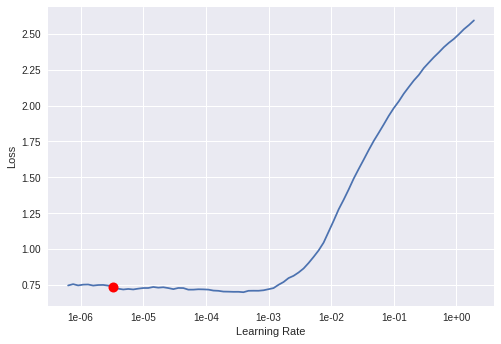

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,0.656672,0.265046,0.054127
2,0.629697,0.261195,0.048714


In [22]:
learn.save('lesson6-pets', return_path=True)

PosixPath('/root/.fastai/data/oxford-iiit-pet/images/models/lesson6-pets.pth')

In [0]:
!cp /root/.fastai/data/oxford-iiit-pet/images/models/lesson6-pets.pth gdrive/"My Drive"/fastai-v3/

## Convolution kernel

In [0]:
data = get_data(352,16)

Category Sphynx

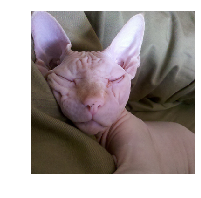

In [26]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [0]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6  # kernel

In [38]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [28]:
k.shape

torch.Size([1, 3, 3, 3])

In [29]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [30]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [0]:
edge = F.conv2d(t[None], k)

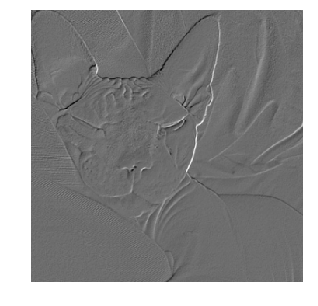

In [32]:
show_image(edge[0], figsize=(5,5));

In [33]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 176, 176]    9,408      True      
______________________________________________________________________
BatchNorm2d          [1, 64, 176, 176]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 176, 176]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 88, 88]      0          False     
______________________________________________________________________
Conv2d               [1, 64, 88, 88]      36,864     True      
______________________________________________________________________
BatchNorm2d          [1, 64, 88, 88]      128        True      
______________________________________________________________________
ReLU                 [1, 64, 88, 88]      0          False     
______________________________________________________________

Next, we'll try to understand how CNNs work by generating a heatmap that shows what the network focused on while making a decision.

## Heatmap

In [0]:
m = learn.model.eval();

In [39]:
m[0]  # in fastai, this is the convolutional part of the model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [0]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
from fastai.callbacks.hooks import *

In [0]:
def hooked_backward(cat=y):
    # hook output of m[0]
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:  # we will see this next week
            preds = m(xb)  # do the forward pass
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [0]:
hook_a,hook_g = hooked_backward()

In [41]:
# fastai hooks give you something called .stored
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [42]:
avg_acts = acts.mean(0)  # mean over all channels
avg_acts.shape

torch.Size([11, 11])

In [0]:
def show_heatmap(hm, show_im=True):
    _,ax = plt.subplots()
    
    if show_im:
        xb_im.show(ax)  # show the image
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),  # overlay heatmap
              interpolation='bilinear', cmap='magma');

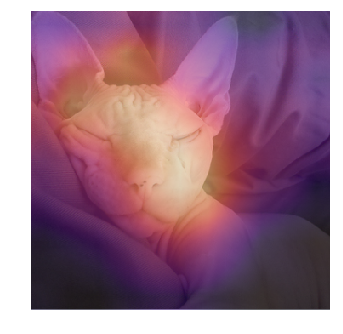

In [48]:
show_heatmap(avg_acts, show_im=True);

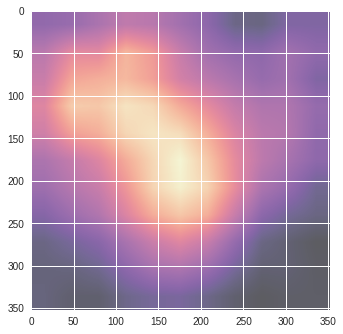

In [49]:
show_heatmap(avg_acts, show_im=False);